In [1]:
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import warnings
import joblib

warnings.simplefilter(action='ignore', category=FutureWarning) # suppress some future warning
pd.options.mode.chained_assignment = None  # default='warn'

from os import path
from scipy.stats import poisson # TODO sostituisci con smf o sm?
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

# custom functions
from libs.utils import fix_continent_matches, show_cdf, show_cdf_splitted, format_dataframe, extract_continent_from_FIFA, check_records_validity, get_match_result, format_columns, get_random_team, make_team_statistics, make_test

plt.style.use('ggplot')

# costanti
PATH_ORIGINAL_DST = 'dataset/original'
PATH_DST = 'dataset'

## Parte 1: Introduzione al dataset, formattazione e verifica

Si prende in analisi un dataset contenente 42483 risultati di partie di calcio internazionale maschile. L'obbiettivo finale del progetto è ottenere un predittore di partite di calcio internazionali, dato l'input.

In [2]:
df = pd.read_csv(path.join(PATH_ORIGINAL_DST ,'results.csv') )

print("Null values:", df.isnull().values.any(), "| shape:", df.shape)
print("***"*15)
print(df.info())

Null values: False | shape: (42483, 9)
*********************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42483 entries, 0 to 42482
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        42483 non-null  object
 1   home_team   42483 non-null  object
 2   away_team   42483 non-null  object
 3   home_score  42483 non-null  int64 
 4   away_score  42483 non-null  int64 
 5   tournament  42483 non-null  object
 6   city        42483 non-null  object
 7   country     42483 non-null  object
 8   neutral     42483 non-null  bool  
dtypes: bool(1), int64(2), object(6)
memory usage: 2.6+ MB
None


### Formattazione del dataset (Pre-processing)
Il dataset non contiene elementi nulli. Estraggo alcune informazioni aggiungendo alcune colonne alle presenti quali:
- L'anno in cui si è giocato il match dalla colonna `date`,
- Ottengo l'`outcome`, che è il risultato dell'incontro e lo popolo con: `Home` per vittoria della squadra di casa, `Draw` per il pareggio e `Away` per vittoria della squadra ospite
- Converto il valore `home_score` e `away_score` in `float` (servirà successivamente)
- Alcuni match risalgono a prima della prima guerra mondiale, di conseguenza alcuni nomi di nazioni e paesi sono cambiati nel tempo (alcune non esistono più o si sono divise in più nazioni)
- Formatto alcuni nomi di nazioni per adattarli al dataset FIFA utilizzato successivamente

In [3]:
df = format_dataframe(df)

In una partita di calcio, la convenzione vuole che la prima squadra è quella di casa.
Per prima cosa controllo dunque che la convenzione sia rispettata:

In [4]:
if len(df.query("away_team == country")) > 0:
    print("Trovati %d record incorenti con la convenzione" % len(df.query("away_team == country")))

Trovati 25 record incorenti con la convenzione


Visto l'esiguo numero di elementi li visualizzo

In [5]:
df.query("away_team == country")

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,outcome,year
788,1924-03-13,Catalonia,Spain,0.0,7.0,Friendly,Barcelona,Spain,False,Away,1924
1618,1933-10-04,Silesia,Poland,1.0,2.0,Friendly,Katowice,Poland,False,Away,1933
1650,1934-02-02,Catalonia,Spain,0.0,2.0,Friendly,Barcelona,Spain,False,Away,1934
2754,1947-10-19,Catalonia,Spain,3.0,1.0,Friendly,Barcelona,Spain,False,Home,1947
3487,1953-04-26,Silesia,Poland,2.0,3.0,Friendly,Chorzów,Poland,False,Away,1953
3526,1953-08-09,Catalonia,Spain,0.0,6.0,Friendly,Barcelona,Spain,False,Away,1953
3539,1953-09-13,Silesia,Poland,3.0,3.0,Friendly,Byton,Poland,False,Draw,1953
28848,2006-11-19,Crimea,Northern Cyprus,0.0,5.0,ELF Cup,Lefkoşa,Northern Cyprus,True,Away,2006
28898,2006-12-09,Silesia,Poland,1.0,1.0,Friendly,Chorzów,Poland,False,Draw,2006
31765,2009-10-28,South Africa,Zimbabwe,1.0,1.0,COSAFA Cup,Harare,Zimbabwe,True,Draw,2009


Vi sono in totale 25 incoerenze che non rispettano la convenzione di sopra.
- I record con `neutral = True` sono incoerenti devono essere cambiati
- I restanti `team` sono antecedenti alle nazioni attuali: ad esempio la <i>Silesia</i> è una regione storica dell'Europa centrale appartenente oggi per la maggiorparte
ai territori della Polonia, Germania e Repubblica Ceca. Questi dati saranno successivamente droppati successivamente.

In [6]:
for i in df.query("away_team == country and neutral == True").index:
    df.at[i, "neutral"] = False

Controllo adesso la presenza di ulteriori incoerenze nel caso in cui `home_team = contry` e `neutral = True`

In [7]:
df.query("home_team == country and neutral == True")

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,outcome,year
10966,1979-08-29,Fiji,Papua New Guinea,0.0,0.0,South Pacific Games,Suva,Fiji,True,Draw,1979
35360,2013-07-15,Bermuda,Falkland Islands,8.0,0.0,Island Games,Hamilton,Bermuda,True,Home,2013
40116,2018-09-09,St. Kitts and Nevis,Puerto Rico,1.0,0.0,CONCACAF Nations League qualification,Basseterre,St. Kitts and Nevis,True,Home,2018
40399,2018-11-18,St. Kitts and Nevis,Canada,0.0,1.0,CONCACAF Nations League qualification,Basseterre,St. Kitts and Nevis,True,Away,2018
40757,2019-06-07,China PR,Philippines,2.0,0.0,Friendly,Guangzhou,China PR,True,Home,2019
41044,2019-08-11,St. Vincent / Grenadines,Trinidad and Tobago,1.0,0.0,Friendly,Georgetown,St. Vincent / Grenadines,True,Home,2019
41046,2019-08-27,St. Kitts and Nevis,Antigua and Barbuda,4.0,3.0,Friendly,Basseterre,St. Kitts and Nevis,True,Home,2019
41110,2019-09-06,USA,Mexico,0.0,3.0,Friendly,East Rutherford,USA,True,Away,2019
41229,2019-09-18,Congo DR,Rwanda,2.0,3.0,Friendly,Kinshasa,Congo DR,True,Away,2019
42068,2021-03-29,Congo DR,Gambia,1.0,0.0,African Cup of Nations qualification,Kinshasa,Congo DR,True,Home,2021


Correggo:

In [8]:
for i in df.query("home_team == country and neutral == True").index:
    df.at[i, "neutral"] = False

In [9]:
not_neutral_games = df.query("neutral == False")

invalid_ = not_neutral_games.query("away_team == country")

invalid_copy = invalid_.copy()

invalid_.loc[invalid_.index.values, 'home_team'] = invalid_copy.loc[invalid_.index.values, 'away_team']
invalid_.loc[invalid_.index.values, 'home_score'] = invalid_copy.loc[invalid_.index.values, 'away_score'] 
invalid_.loc[invalid_.index.values, 'away_team'] = invalid_copy.loc[invalid_.index.values, 'home_team'] 
invalid_.loc[invalid_.index.values, 'away_score'] = invalid_copy.loc[invalid_.index.values, 'home_score'] 
invalid_['outcome'] = invalid_['outcome'].replace({"Home": "Away", "Away":"Home"})

for i in invalid_.index.values:
    df.loc[i, 'home_team'] = invalid_.loc[i, 'home_team']
    df.loc[i, 'home_score'] = invalid_.loc[i, 'home_score']
    df.loc[i, 'away_team'] = invalid_.loc[i, 'away_team']
    df.loc[i, 'away_score'] = invalid_.loc[i, 'away_score']
    df.loc[i, 'outcome'] = invalid_.loc[i, 'outcome']

In [10]:
df.to_csv(path.join(PATH_DST, 'dataset_v1.csv'))

Data la presenza di partite di nazioni non più presenti e dato l'obbiettivo iniziale del dataset di predirre il risultato di un match dato lo storico
dei risultati delle rispettive squadre è necessario non considerare una parte dei record presenti. Per fare ciò, filtro le squadre utilizzando il dataset [FIFA-RANKING](http://en.fifaranking.net/data/)

In [11]:
df_fifa = pd.read_csv(path.join(PATH_ORIGINAL_DST, 'fifa_ranking-2021-05-27.csv'))

df_fifa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63054 entries, 0 to 63053
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               63054 non-null  int64 
 1   rank             63054 non-null  int64 
 2   country_full     63054 non-null  object
 3   country_abrv     63054 non-null  object
 4   total_points     63054 non-null  int64 
 5   previous_points  63054 non-null  int64 
 6   rank_change      63054 non-null  int64 
 7   confederation    63054 non-null  object
 8   rank_date        63054 non-null  object
dtypes: int64(5), object(4)
memory usage: 4.3+ MB


Il dataset presenta 8 colonne che contengono le informazioni sulle quadre internazionali che partecipano alle competizioni FIFA.
La funzione `check_records_validity` permette di filtrare tutti i match presenti nel dataset di riferimento e verificare l'appartenenza delle due squadre nel dataset FIFA.

In [12]:
df = pd.read_csv(path.join(PATH_DST, 'dataset_v1.csv')).drop(columns=["Unnamed: 0"])

df = check_records_validity(df, df_fifa)

df_valid = df.query("is_valid == True").drop(columns=['is_valid']).reset_index(drop=True)
df_not_valid = df.query("is_valid == False").drop(columns=['is_valid']).reset_index(drop=True)

# mantengo nella variabile principale solo i record validi del dataframe
df = df_valid

if len(df_valid) + len(df_not_valid) == len(df):
    print("valid: %s not valid: %s, totale di record esaminati %s" % ( len(df_valid),len(df_not_valid), len(df) ) )
else:
    print("Something wrong happened!")

Total country: 216
Something wrong happened!


Dato che servirà successivamente, realizzo un dataframe, che salverò come csv con  l'elenco delle nazioni che hanno giocato almeno 1 match con la rispettiva confederazione

In [13]:
df_fifa = df_fifa.drop(columns=['id','rank', 'country_abrv', 'total_points', 'previous_points', 'rank_change', 'rank_date']).sort_values(by='country_full').drop_duplicates().reset_index(drop=True)

df_unvalid_country = pd.DataFrame()

# estraggo tutti i team presenti in dataset_reduced_fixed
df_ht = df_valid['home_team'].drop_duplicates().sort_values().reset_index().drop(labels=['index'], axis=1).rename(columns={'home_team': 'team'})
df_at = df_valid['away_team'].drop_duplicates().sort_values().reset_index().drop(labels=['index'], axis=1).rename(columns={'away_team': 'team'})

df_valid_country = pd.concat([df_ht,df_at]).drop_duplicates().sort_values(by='team').reset_index().drop(labels=['index'], axis=1)

df_valid_country['confederation'] = ""

for i, row in df_valid_country.iterrows():
    if(len(df_fifa.query("country_full == @row.team")) > 0):
        df_valid_country.at[i, 'confederation'] = df_fifa.query("country_full == @row.team").confederation.values[0]

df_valid_country.replace("", np.nan, inplace=True)

df_unvalid_country = df_valid_country[df_valid_country['confederation'].isna()]
df_unvalid_country.reset_index(drop=True, inplace=True)
df_unvalid_country.drop(labels=['confederation'], axis=1, inplace=True)

df_valid_country.dropna(subset = ['confederation'], inplace=True)
df_valid_country.reset_index(drop=True, inplace=True)

print("... Fixed. Number of teams: %d" % len(df_valid_country))

df_valid_country.to_csv(path.join(PATH_DST, 'valid_country.csv'))
df_unvalid_country.to_csv(path.join(PATH_DST, 'not_valid_country.csv'))

... Fixed. Number of teams: 209


Procedo con l'eliminazione di tutti i match in cui una delle due squadre è presente in `df_unvalid_countries`

In [14]:
for index, row in df_unvalid_country.iterrows():
    if(len(df.query("home_team == @row.team or away_team == @row.team")) > 0):
        df.drop(df.query("home_team == @row.team or away_team == @row.team").index.values, inplace=True)

print("Now dataset is formed by: %d records"% len(df))

Now dataset is formed by: 39029 records


Per evitare la presenza di ulteriori record incoerenti, controllo che tutte le squadre presenti nel dataset abbiano giocato almeno una partita in casa e fuori casa

In [15]:
if len(df['home_team'].drop_duplicates().sort_values().values) > len(df['away_team'].drop_duplicates().sort_values().values):
    print("Mismatch home_team > away_team: %s" % list(set(df['home_team'].drop_duplicates().sort_values().values).difference(df['away_team'].drop_duplicates().sort_values().values)))
elif len(df['home_team'].drop_duplicates().sort_values().values) < len(df['away_team'].drop_duplicates().sort_values().values):
    print("Mismatch home_team < away_team: %s" % list(set(df['away_team'].drop_duplicates().sort_values().values).difference(df['home_team'].drop_duplicates().sort_values().values)))
else:
    print("Home teams and away teams are the same")

Mismatch home_team > away_team: ['St. Kitts and Nevis']


In [16]:
df = df.reset_index(drop=True)
df.to_csv(path.join(PATH_DST, "v2/dataset.csv"))

## Parte 2: Statistica descrittiva - Distribuzione dei dati

In [17]:
df = pd.read_csv(path.join(PATH_DST, 'v2/dataset.csv')).drop(columns=['Unnamed: 0'])

### Competizioni presenti nel dataset
Tramite un grafico a barre visualizzo il numero di competizioni giocate e la relativa frequenza

Numero di competizioni: 109


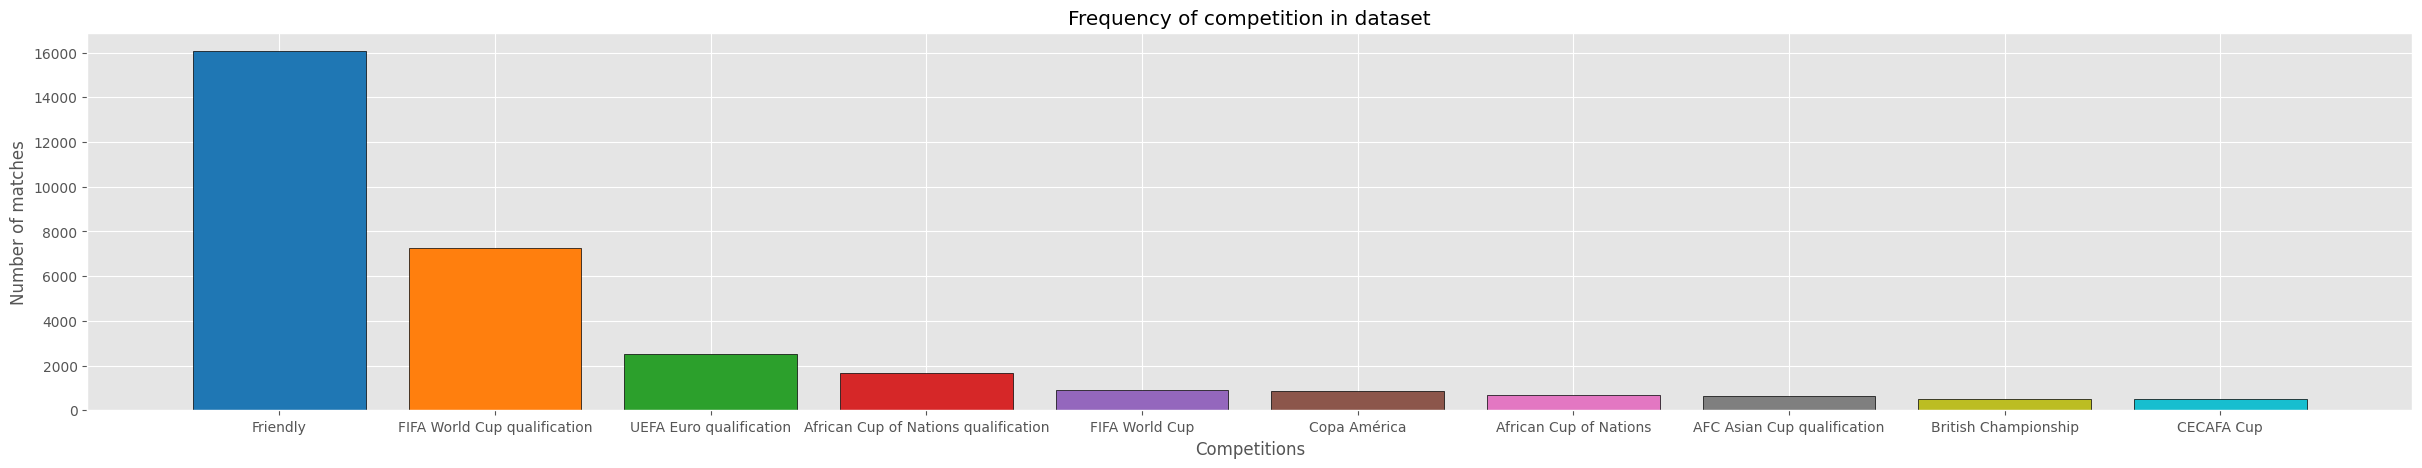

In [18]:
tournaments = df['tournament'].value_counts()

print("Numero di competizioni: %d" % ( len(tournaments) ))

plt.rcParams.update({'figure.figsize':(30,5), 'figure.dpi':100})
plt.title('Frequency of competition in dataset')
plt.ylabel('Number of matches')
plt.xlabel('Competitions')
plt.bar(tournaments.index[:10], tournaments.values[:10], color=[i for i in mcolors.TABLEAU_COLORS], edgecolor='black')
plt.show()

La maggiorparte delle partite disputate sono amichevoli seguiti dalle fasi di qualificazione dei 3 principali tornei mondiali FIFA

### Numero di partite disputate per anno

Visualizzo il numero di partite giocate per anno

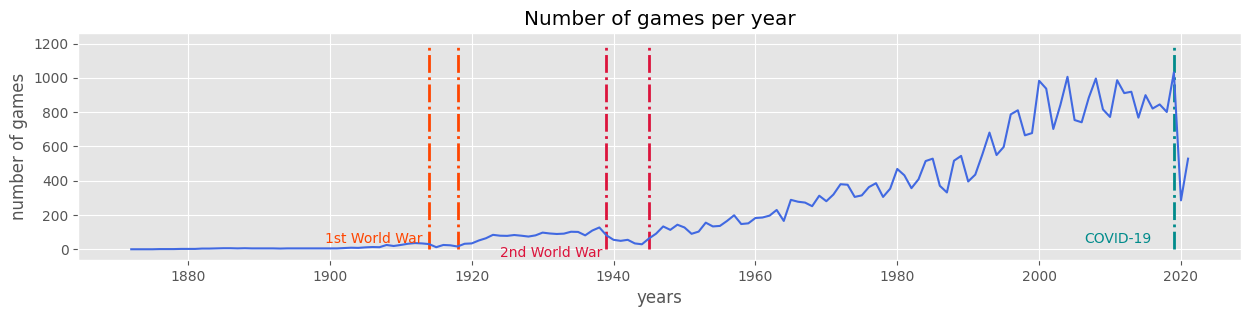

In [19]:
mpy = df['year'].value_counts().sort_index() # matches per year

plt.rcParams.update({'figure.figsize':(15,3), 'figure.dpi':100})
plt.title(label='Number of games per year')
plt.ylabel(ylabel='number of games')
plt.xlabel(xlabel='years')

l1 = [(1914,0), (1914,1200)]
l2 = [(1918,0), (1918,1200)]
l3 = [(1939,0), (1939,1200)]
l4 = [(1945,0), (1945,1200)]
l5 = [(2019,0), (2019, 1200)]

lc = LineCollection([l1, l2, l3, l4, l5], color=["orangered","orangered", "crimson","crimson", "darkcyan"], lw=2, linestyles='-.')

plt.annotate('1st World War', xy=(1914, 200), xycoords='data', ha='center', xytext=(-40, -20), textcoords='offset points', color='orangered')
plt.annotate('2nd World War', xy=(1939, 200), xycoords='data', ha='center', xytext=(-40, -30), textcoords='offset points', color='crimson')
plt.annotate('COVID-19', xy=(2019, 200), xycoords='data', ha='center', xytext=(-40, -20), textcoords='offset points', color='darkcyan')

plt.gca().add_collection(lc)

plt.plot(mpy, color='royalblue')
plt.grid(True)
plt.show()

Il numero di match si è abbassato durante le Guerre Mondiali ed è drasticamente calato durante la pandemia di Covid-19 ad inizio 2020.

### Numero di partite ospitate da ogni continente per anno

Per visualizzare l'adozione del calcio nel mondo visualizzo tramite ad un barplot il numero di partite ospitate da ogni continente per anno. Utilizzo nuovamente il dataset FIFA a disposizione
per estrarre il contienente in cui si è disputato il match.

In [20]:
df_fifa = pd.read_csv(path.join(PATH_ORIGINAL_DST,'fifa_ranking-2021-05-27.csv'))
df = extract_continent_from_FIFA(df, df_fifa)
df.to_csv(path.join(PATH_DST, "v2/dataset_continent.csv"))

# dataframe continent reduced, salvandolo a csv risolvo il problema del groupby che non assegna a tutte le colonne i continenti
df_cr = df.groupby(['continent','year']).size().to_csv('output.csv')
df_cr = pd.read_csv('output.csv')

# ordino per anno
df_cr.sort_values(by='year', axis=0, inplace=True)
df_cr = df_cr.reset_index().drop(columns=['index']).rename(columns={'0': 'matches'})

if df.__len__() == df_cr['matches'].sum():
    print("Groupby eseguito correttamente")

years = df_cr['year'].drop_duplicates().to_numpy()

africa = df_cr[df_cr['continent'] == 'Africa' ].reset_index().drop(columns=['continent', 'index'])
america = df_cr[df_cr['continent'] == 'America'].reset_index().drop(columns=['continent', 'index'])
asia = df_cr[df_cr['continent'] == 'Asia'].reset_index().drop(columns=['continent', 'index'])
europe = df_cr[df_cr['continent'] == 'Europe'].reset_index().drop(columns=['continent', 'index'])
oceania = df_cr[df_cr['continent'] == 'Oceania'].reset_index().drop(columns=['continent', 'index'])

All rows are correctly updated
Groupby eseguito correttamente


Data l'adozione non uniforme dello sport per i vari continenti, uniformizzo la lunghezza dei DataFrame con la funzione `fix_continent_matches`

First appearance in national match:
Africa: 1926
America: 1885
Asia: 1917
Europe: 1872
Oceania: 1922
All df have the same number of rows


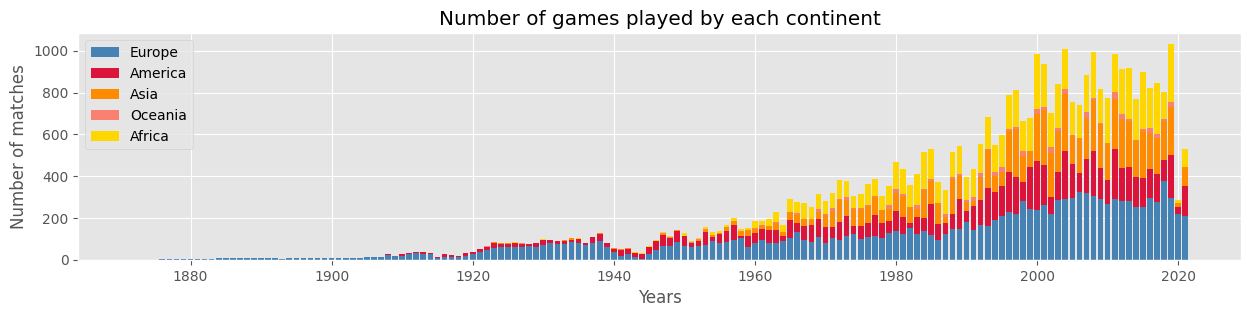

In [21]:
print("First appearance in national match:\nAfrica: %d\nAmerica: %d\nAsia: %d\nEurope: %d\nOceania: %d" % (africa['year'].min(), america['year'].min(), asia['year'].min(), europe['year'].min(), oceania['year'].min() ))
africa  =   fix_continent_matches(years, africa)
america =   fix_continent_matches(years, america)
asia    =   fix_continent_matches(years, asia)
europe  =   fix_continent_matches(years, europe)
oceania =   fix_continent_matches(years, oceania)

if len(africa) == len(europe) == len(america) == len(oceania) == len(asia):
    print("All df have the same number of rows")

plt.rcParams.update({'figure.figsize':(15,3), 'figure.dpi':100})
plt.title('Number of games played by each continent')
plt.ylabel('Number of matches')
plt.xlabel('Years')
plt.bar(years, europe.matches.values, color='steelblue')
plt.bar(years, america.matches.values, bottom=europe.matches.values , color='crimson')
plt.bar(years, asia.matches.values, bottom = europe.matches.values+america.matches.values, color='darkorange')
plt.bar(years, oceania.matches.values, bottom = europe.matches.values+america.matches.values+asia.matches.values , color='salmon')
plt.bar(years, africa.matches.values, bottom=europe.matches.values + america.matches.values + asia.matches.values + oceania.matches.values, color='gold')
plt.legend(['Europe', 'America', 'Asia', 'Oceania', 'Africa'])

plt.show()

Dal grafico si evince che Europa ed America sono i continenti dove si sono disputato più partite.
Il numero di partite disputate in oceania è irrilevante rispetto al numero degli altri continenti nonostante l'Africa sia stata l'ultima ad aver ospitato una partita ufficiale.

### Estrazione statistiche squadre presenti nel dataset
Prima di procedere con il calcolo delle statistiche di ogni squadra non considero i match giocati dalle squadre non presenti in `valid_country.csv` creato precedentemente, dato che da questo momento non sono più influenti.

In [22]:
df = pd.read_csv(path.join(PATH_DST, 'v2/dataset_continent.csv')).drop(columns=['Unnamed: 0'])

valid_country = pd.read_csv(path.join(PATH_DST, 'valid_country.csv')).drop(columns=['Unnamed: 0']).team.values
df_country = df.country.drop_duplicates().values

not_valid_country = []

for i in df_country:
    if i not in valid_country:
        not_valid_country.append(i)

print("Lunghezza del dataframe prima della validazione: %s" % (len(df)) )

for i, row in df.iterrows():
    if(row.country in not_valid_country):
        df.drop(i, inplace=True)

print("Lunghezza del dataframe dopo la validazione: %s" % (len(df)) )

df = df.reset_index(drop=True).to_csv(path.join(PATH_DST, 'v3/dataset.csv'))

Lunghezza del dataframe prima della validazione: 39029
Lunghezza del dataframe dopo la validazione: 38205


Realizzo un dataframe con le statistiche delle squadre in dettaglio. In particolare il nuovo DataFrame contiene:
- il numero di partite giocate
- il numero di partite giocate, in casa, fuori casa e in campo neutrale,
- il numero di vittorie totali, in casa, fuori casa e in campo neutrale,
- il numero di sconfitte totali, in casa, fuori casa e in campo neutrale,
- il numero di pareggi totali, in casa, fuori casa e in campo neutrale,
- il numero di goal concessi totali, in casa, fuori casa e in campo neutrale.


In [23]:
df = pd.read_csv(path.join(PATH_DST, 'v3/dataset.csv')).drop(columns=['Unnamed: 0'])
teams = pd.read_csv(path.join(PATH_DST, 'valid_country.csv')).drop(columns=['Unnamed: 0'])

teams_statistics = make_team_statistics(df, teams)

teams_statistics.to_csv(path.join(PATH_DST, 'teams_statistics.csv'))

Nel salvo una versione coi valori in percentuale:

In [24]:
for i in teams_statistics.columns.values[3:]:
    teams_statistics[i] = teams_statistics[i].astype(float)

for i, row in teams_statistics.iterrows():
    for j in teams_statistics.columns.values[3:]:
        # per calcolare la percentuale moltiplico * 100 il rapporto tra la statistica quantitativa e partite giocate in totale
        teams_statistics.at[i, j] = row[j] / row['games'] * 100

teams_statistics.to_csv(path.join(PATH_DST, 'teams_statistics_perc.csv'))

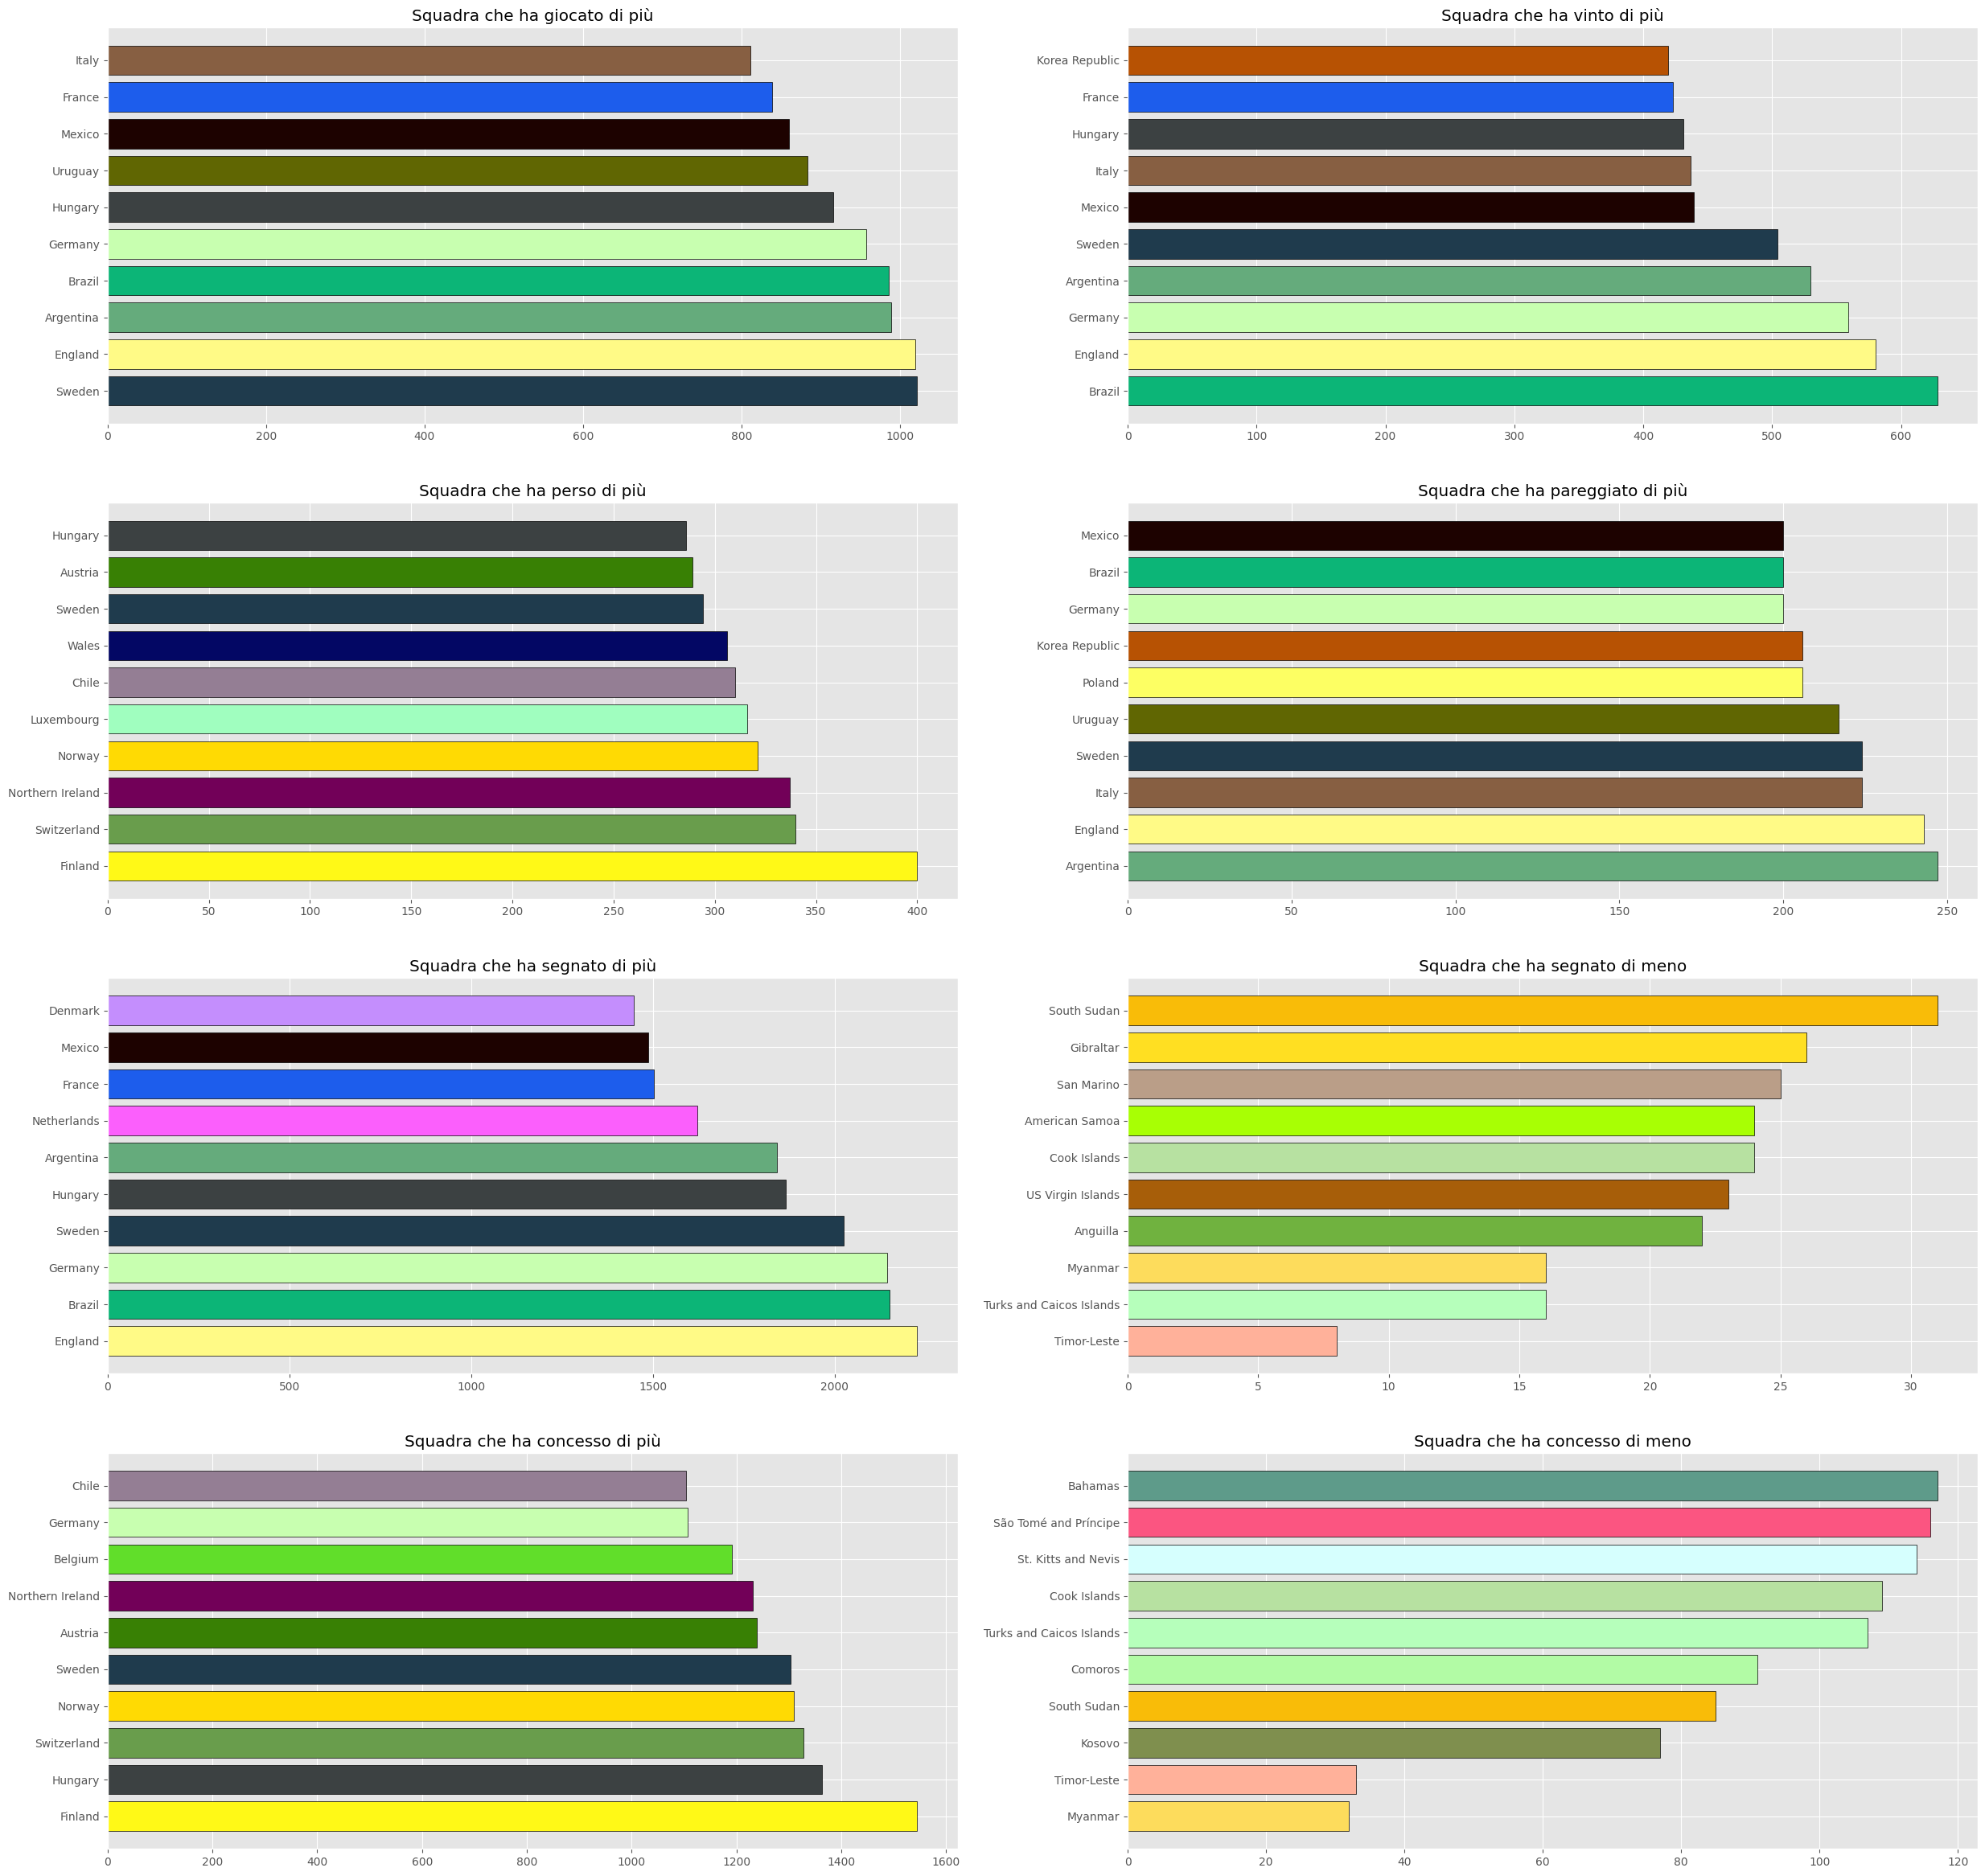

In [25]:
plt.rcParams.update({'figure.figsize':(30,30), 'figure.dpi':100})
fig, axs = plt.subplots(4, 2)

df = pd.read_csv(path.join(PATH_DST, 'teams_statistics.csv')).drop(columns=['Unnamed: 0'])
colors = list(mcolors.XKCD_COLORS)
df['color'] = colors[:len(df)]

df_axs = df.sort_values(by=['games'], ascending=False)
axs[0, 0].set_title("Squadra che ha giocato di più")
axs[0, 0].barh(df_axs.team.values[:10], df_axs.games.values[:10], color=df_axs.color.values[:10], edgecolor='black')

df_axs = df.sort_values(by=['wins'], ascending=False)
axs[0, 1].set_title("Squadra che ha vinto di più")
axs[0, 1].barh(df_axs.team.values[:10], df_axs.wins.values[:10], color=df_axs.color.values[:10], edgecolor='black')

df_axs = df.sort_values(by=['defeats'], ascending=False)
axs[1, 0].set_title("Squadra che ha perso di più")
axs[1, 0].barh(df_axs.team.values[:10], df_axs.defeats.values[:10], color=df_axs.color.values[:10], edgecolor='black')

df_axs = df.sort_values(by=['draws'], ascending=False)
axs[1, 1].set_title("Squadra che ha pareggiato di più")
axs[1, 1].barh(df_axs.team.values[:10], df_axs.draws.values[:10], color=df_axs.color.values[:10], edgecolor='black')

df_axs = df.sort_values(by=['goals_scored'], ascending=False)
axs[2, 0].set_title("Squadra che ha segnato di più")
axs[2, 0].barh(df_axs.team.values[:10], df_axs.goals_scored.values[:10], color=df_axs.color.values[:10], edgecolor='black')

df_axs = df.sort_values(by=['goals_scored'], ascending=True)
axs[2, 1].set_title("Squadra che ha segnato di meno")
axs[2, 1].barh(df_axs.team.values[:10], df_axs.goals_scored.values[:10], color=df_axs.color.values[:10], edgecolor='black')

df_axs = df.sort_values(by=['goals_conceded'], ascending=False)
axs[3, 0].set_title("Squadra che ha concesso di più")
axs[3, 0].barh(df_axs.team.values[:10], df_axs.goals_conceded.values[:10], color=df_axs.color.values[:10], edgecolor='black')

df_axs = df.sort_values(by=['goals_conceded'], ascending=True)
axs[3, 1].set_title("Squadra che ha concesso di meno")
axs[3, 1].barh(df_axs.team.values[:10], df_axs.goals_conceded.values[:10], color=df_axs.color.values[:10], edgecolor='black')

plt.show()

Voglio adesso verificare se vi è una relazione tra l'esito di un match e il possibile esito (vittoria, pareggio, sconfitta). Per fare ciò ho la necessità di calcolare la covarianza per misurare quanto le due variabili varino insieme (in quanto sono dati multivariati, che è il corrispettivo della varianza nel caso di dati bivariati) la cui formula è:

\begin{equation}
\sigma_{XY} = \frac{1}{N}\sum_i^N (x_i - \overline x) (y_i - \overline y)
\end{equation}

Mi avvalgo di una scattermatrix per visualizzare le covarianze di `goal concessi`, `goal subiti`, `vittorie`, `pareggi` e `sconfitte` e verificare se vi è linearità tra le variabili:

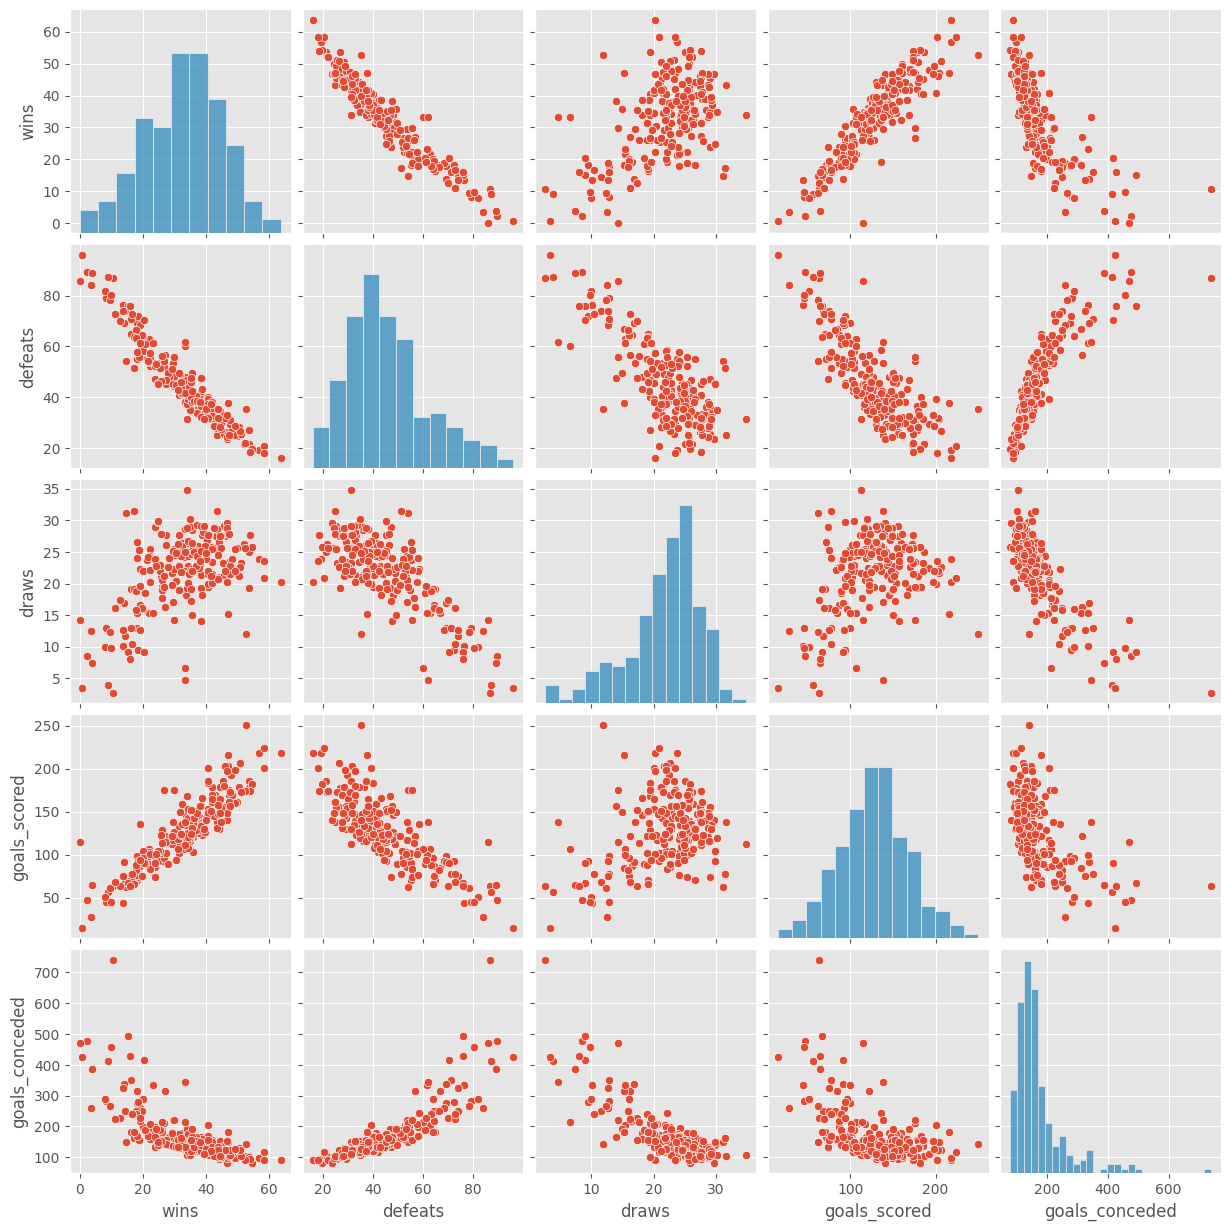

In [26]:
df = pd.read_csv(path.join(PATH_DST, 'teams_statistics_perc.csv')).drop(columns=['Unnamed: 0','games', 'home_games', 'away_games',
    'neutral_games','home_wins', 'away_wins', 'neutral_wins','home_defeats', 'away_defeats', 'neutral_defeats','home_draws', 'away_draws', 'neutral_draws','home_goals_scored', 'away_goals_scored',
    'neutral_goals_scored','home_goals_conceded',
    'away_goals_conceded', 'neutral_goals_conceded'])

sns.pairplot(df)
plt.show()

Dato l'andamento lineare tra le variabili mi avvalgo dell'indice di correlazione Pearson per quantificare la correlazione espressa sopra, la cui formula $ r_{xy} = \frac{c_{xy}}{s_xs_y} $ :
- $ -1 < r_{xy} < 1 $
- Per $ r_{xy} = 0 $ le due variabili cono incorrelate
- $ s_{x} s_{y} $ sono le deviazioni standard dei rispettivi attributi
- Valori superiori a `0.5` indicano una buona correlazione positiva
- Valori inferiori a `-0.5` indicano una buona correlazione negativa
- Valori prossimi a `1` indicano una forte correlazione positiva
- Valori prossimi a `-1` indicano una forte correlazione negativa

Introduco inoltre la nuova variabile `goal_difference` (differenza reti) ottenuta dalla sottrazione tra i goal concessi da quelli effettuati.


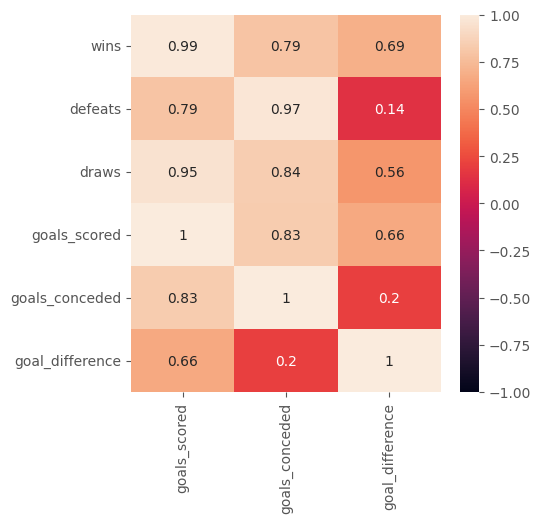

In [27]:
df = pd.read_csv(path.join(PATH_DST, 'teams_statistics.csv')).drop(columns=['Unnamed: 0','games', 'home_games', 'away_games',
    'neutral_games','home_wins', 'away_wins', 'neutral_wins','home_defeats', 'away_defeats', 'neutral_defeats','home_draws', 'away_draws', 'neutral_draws','home_goals_scored', 'away_goals_scored',
    'neutral_goals_scored','home_goals_conceded',
    'away_goals_conceded', 'neutral_goals_conceded'])

df['goal_difference'] = df['goals_scored'] - df['goals_conceded']

plt.figure(figsize=(5, 5))
sns.heatmap(df.corr(method='spearman')[['goals_scored','goals_conceded', 'goal_difference']], vmin=-1, vmax=1, annot=True)

plt.show()

Dai risultati di sopra si può evincere che
- La differenza goal dipende più dai goal subiti che da quelli segnati
- La vittoria dipende di più dai goal concessi rispetto a quelli subiti
- Vi è una buona correlazione tra goal concessi ed effettuati

Visualizzo infine la matrice di correlazione di tutti i parametri presenti nel dataset di riferimento

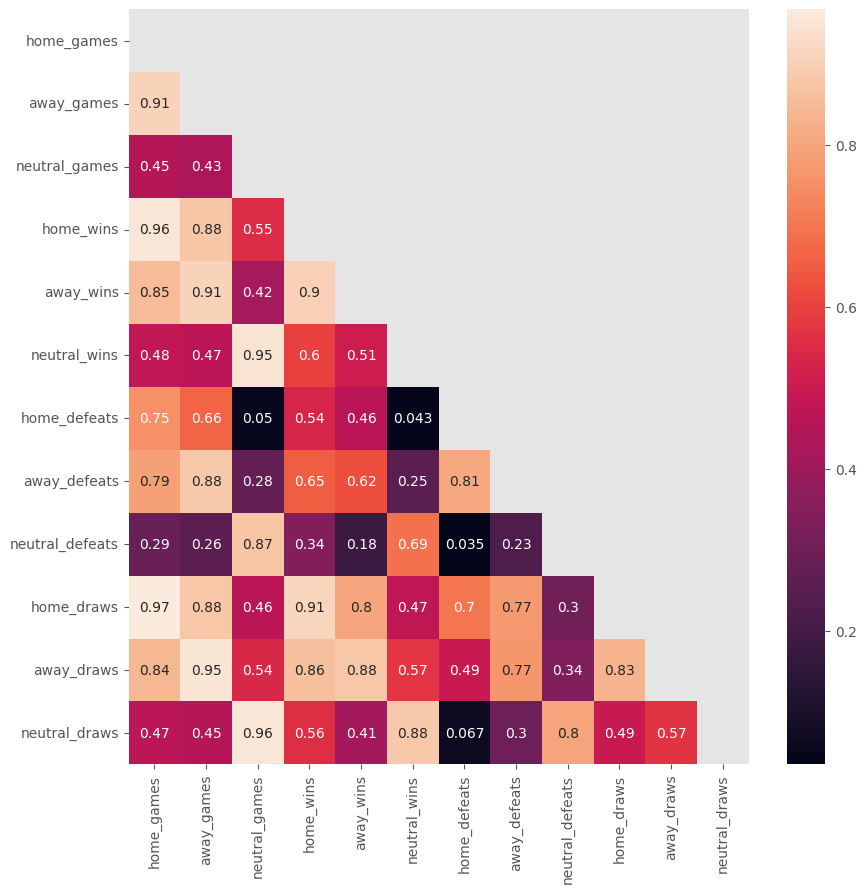

In [28]:
df = pd.read_csv(path.join(PATH_DST, 'teams_statistics.csv')).drop(columns=['Unnamed: 0', 'confederation', 'games','wins','defeats','draws','goals_scored', 'home_goals_scored', 'away_goals_scored',
    'neutral_goals_scored', 'goals_conceded', 'home_goals_conceded',
    'away_goals_conceded', 'neutral_goals_conceded'])


plt.figure(figsize=(10, 10))

mask = np.zeros_like(df.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df.corr(),annot=True, mask = mask)
plt.show()

## Parte 3 - Proposta modello ed implementazione

L'obbiettivo finale è quello di implementare un modello che permetta di predirre il risultato di un match date le due squadre in input. Per implementare quest'ultima parte del progetto utilizzo la terza versione del dataset.

In [29]:
df = pd.read_csv(path.join(PATH_DST, 'v3/dataset.csv')).drop(columns=['Unnamed: 0'])

Realizzo una funzione visualizza graficamente somma cumulativa degli esiti, dato in unput una squadra. La funzione `get_random_team` una tra le squadre disponibili del dataset randomicamente

28 wins
23 draws
32 defeats


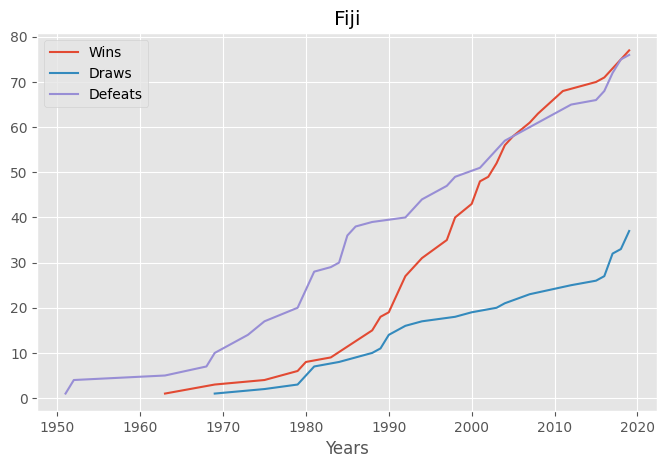

In [30]:
selected_team = get_random_team()
plt.rcParams.update({'figure.figsize':(8,5), 'figure.dpi':100})
show_cdf(df, selected_team)

Visualizzo la somma cumulativa dei risultati nel caso in cui la partita sia giocata in casa, fuori casa o in campo neutrale

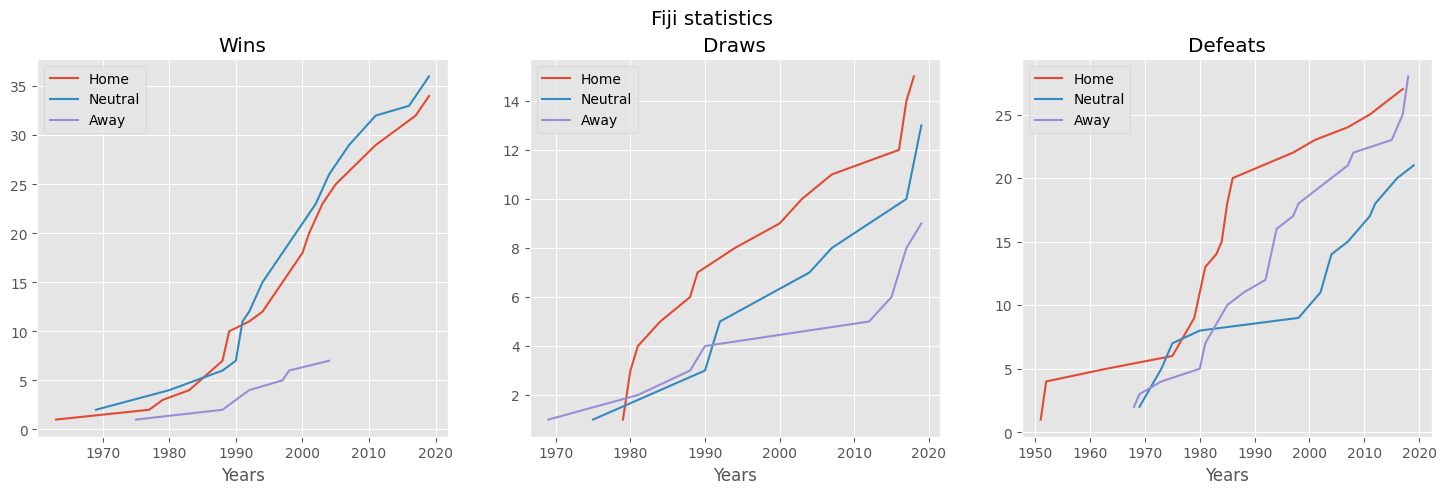

In [31]:
plt.rcParams.update({'figure.figsize':(18,5), 'figure.dpi':100})
show_cdf_splitted(df, selected_team)

Caso italiano:

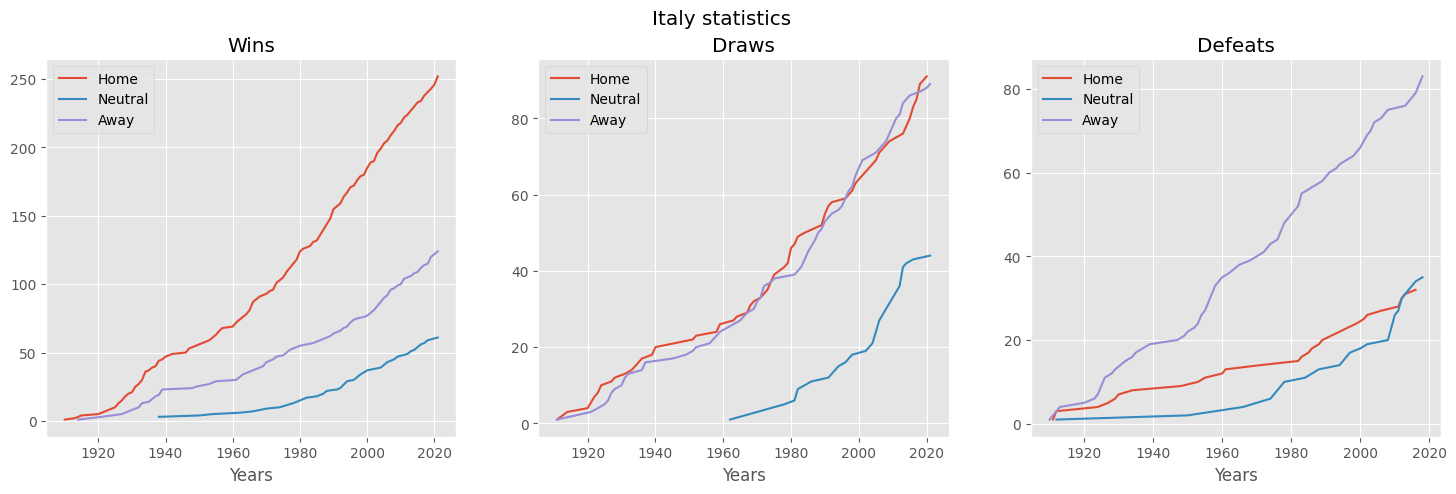

In [32]:
plt.rcParams.update({'figure.figsize':(18,5), 'figure.dpi':100})
show_cdf_splitted(df, 'Italy')

In questo caso, l'Italia tende a vincere o perdere in casa. Mentre Le sconfitte vengono perlopiù quando gioca fuori casa.
Nel caso generale il numero di vittorie è maggiore rispetto a quello delle sconfitte e dei pareggi.

Utilizzo dei Boxplot per avere un primo confronto della differenza di goal segnati dalle due squadre in campo neutrale e non. Nel primo caso `home_team` ed `away_team` sono da intendere come due squadre entrambe in trasferta

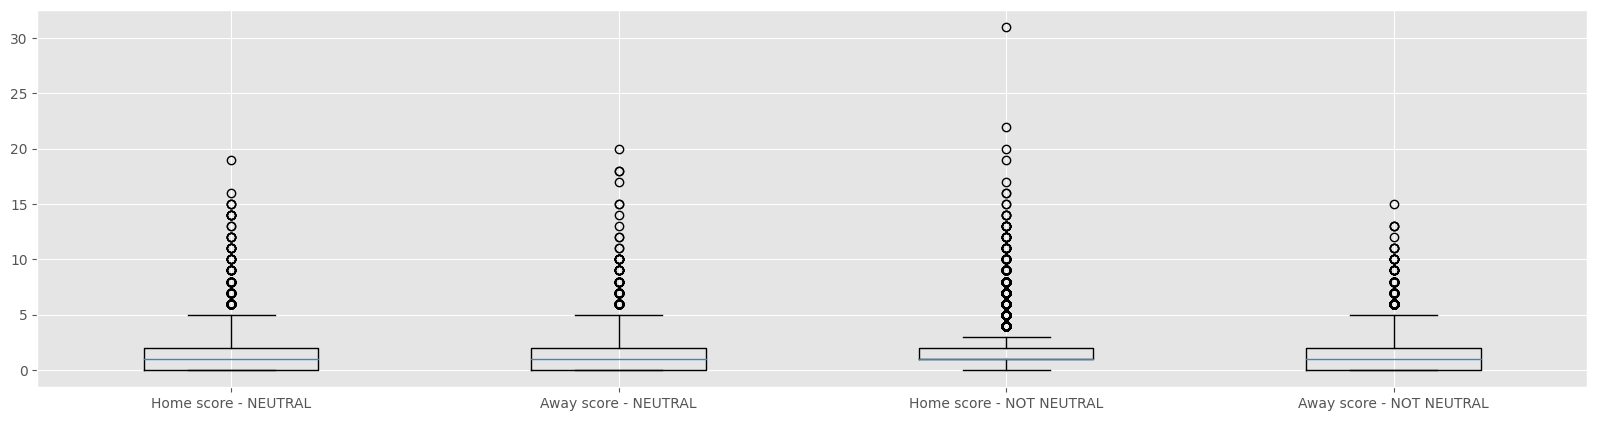

In [33]:
neutral_games = df.query("neutral == True")
not_neutral_games = df.query("neutral == False")

plt.figure(figsize=(20,5))
scores = {
    'Home score - NEUTRAL': neutral_games['home_score'],
    'Away score - NEUTRAL': neutral_games['away_score'],
    'Home score - NOT NEUTRAL': not_neutral_games['home_score'],
    'Away score - NOT NEUTRAL': not_neutral_games['away_score'],
    }
plt.boxplot(scores.values())

ax = plt.gca()
ax.set_xticklabels(scores.keys())

plt.show()

Sono presenti molti outliers, che andranno comunque considerati per rendere il modello più 'reale' possibile (sono stati effettuati dei test, antecedenti alla stesura di questi commenti) . Inoltre sembra che la squadra che giochi in casa tenda a segnare meno rispetto alla squadra fuori casa.

### Individuo la distribuzione

Per implementare un buon modello è necessario prima individuare la distribuzione notevole che più approssima il campione preso in esame.<br>
Visualizzo le distribuzioni di `home_score` ed `away_score` utilizzando l'istogramma e la relativa PDF (Probability Density Function che associa ad ogni valore continuo la relativa probabilità)

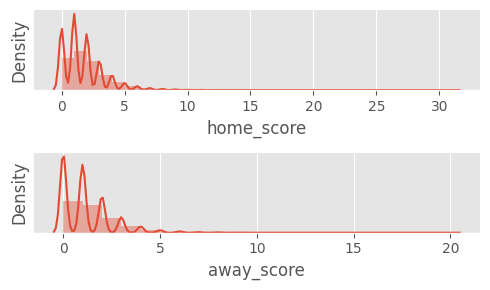

Skewness home_score: 1.995785
Skewness away_score: 2.095158
Kurtosis home_score: 1.995785
Kurtosis away_score: 2.095158


In [34]:
plt.rcParams.update({'figure.figsize':(5,3), 'figure.dpi':100})
fig, axs = plt.subplots(2,1)
sns.despine(left=True)

sns.distplot(df['home_score'], ax=axs[0], bins=np.arange(df['home_score'].min(), df['home_score'].max()))
sns.distplot(df['away_score'], ax=axs[1], bins=np.arange(df['away_score'].min(), df['away_score'].max()))

plt.setp(axs, yticks=[])
plt.tight_layout()
plt.show()

print("Skewness home_score: %f" % df['home_score'].skew())
print("Skewness away_score: %f" % df['away_score'].skew())
print("Kurtosis home_score: %f" % df['home_score'].skew())
print("Kurtosis away_score: %f" % df['away_score'].skew())

Entrambe le distribuzioni sono asimmetriche a sinistra. Rispettivamente la:
- Curtosi misura lo spessore delle corde di una misura di densità, la cui formula su pandas è
$$ \begin{equation} k=\frac{m^4}{\sigma^4} - 3 \end{equation} $$

- Skewness misura se la distribuzione dei dati è sbilanciata

In questo caso entrambe le distribuzioni sono sbilanciate a destra ( sk > 0 ) ed essendo l'indice di curtosi prossimo a 2 si parlerà di una distribuzione leptocurtica (più appuntita di una normale)


Tra le distribuzioni notevoli trattate, quella che si avvicina di più al caso preso in esame è la distribuzione di Poisson. È una distribuzione di probabilità discreta calcolata in un intervallo di tempo . Dato  numero medio di occorrenze del fenomeno sotto studio durante l’intervallo T, la distribuzione fornisce la probabilità che durante un intervallo T si verifichino n occorrenze del fenomeno mediante la formula:

$$
\begin{equation}
P(n,\lambda) = {\frac{\lambda^n}{n!}e^{-\lambda}} \ \ \ {\forall n \in \mathbb{N}}
\end{equation}
$$

Confronto dunque l'istogramma delle due variabili, ed assumendo che la distribuzione prima citata vada bene, controllo che vi assomigli in un grafico.

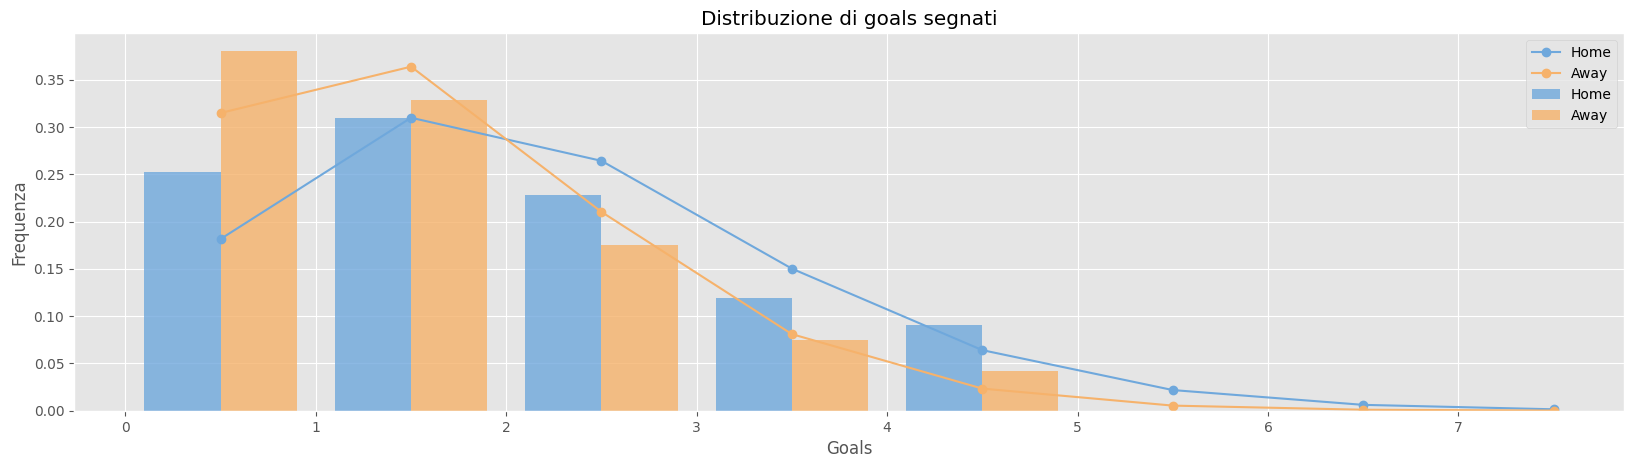

In [35]:
plt.figure(figsize=(20,5))

plt.hist(df[['home_score', 'away_score']].values, range(6), alpha=0.8, label=['Home', 'Away'], density=True, color=["#6fa8dc", "#f6b26b"])

means = df[['home_score','away_score']].mean()
# predizioni di poisson di ogni goal per la media dei goal
poisson_pred = np.column_stack([[poisson.pmf(k, means[j]) for k in range(8)] for j in range(2)])

plt.plot([i-0.5 for i in range(1,9)], poisson_pred[:,0],linestyle='-', marker='o',label="Home", color = '#6fa8dc')
plt.plot([i-0.5 for i in range(1,9)], poisson_pred[:,1],linestyle='-', marker='o',label="Away", color = '#f6b26b')

plt.legend()
plt.title("Distribuzione di goals segnati")
plt.xlabel("Goals")
plt.ylabel("Frequenza")
plt.show()

Vista la somiglianza posso procedere con l'implementazione del modello. Voglio, prima di implementare il modello se vi è correlazione tra partite giocate in campo neutrale ed i goal effettuati.

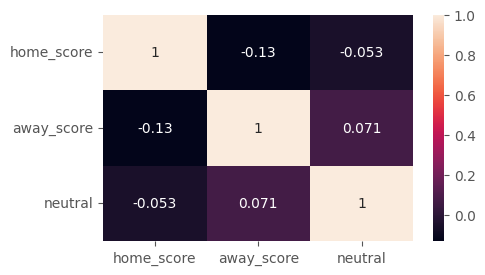

In [36]:
sns.heatmap(df.drop(columns=['year']).corr(),annot=True)
plt.show()

Vi è una bassissima correlazione negativa tra `home_score` e `neutral` ed una bassa correlazione positiva `away_score` e `neutral`. Posso assumere dunque che il campo neutrale non influenza l'andamento del match

## Parte 4 - Implementazione del modello

Dopo aver individuato la distribuzione (ed effettuato altri test utilizzando altri modelli, consultabili in `test_model.py`), è stato trovato opportuno procedere con l'implementazione del modello di Poisson considerando solamente gli attributi `home_team` `away_team` per predirre `outcome`. Droppo dunque tutte le colonne non necessarie per semplificare.

In [37]:
df = pd.read_csv(path.join(PATH_DST, 'v3/dataset.csv')).drop(columns=['Unnamed: 0', 'tournament', 'city', 'country', 'neutral', 'outcome', 'year', 'continent'])
df['home_team'] = df['home_team'].str.replace(" ", "_")
df['away_team'] = df['away_team'].str.replace(" ", "_")

Riadatto il dataset per utilizzarlo nel modello, voglio ottenere un dataset che mi permetta di allenare un modello che predica i goal fatti `team1` a `team2`, per poi da questo calcolarne l'outcome. Dunque adatto il dataset al caso:

In [38]:
datamodel = pd.concat([df[['home_team','away_team','home_score']].rename(columns={'home_team':'team1', 'away_team':'team2','home_score':'goals'}), df[['away_team','home_team','away_score']].rename(columns={'away_team':'team1', 'home_team':'team2','away_score':'goals'})])
print("Datamodel len: %d" % ( len(datamodel) ))
datamodel.head()

Datamodel len: 76410


,team1,team2,goals
0,Scotland,England,0.0
1,England,Scotland,4.0
2,Scotland,England,2.0
3,England,Scotland,2.0
4,Scotland,England,3.0


Alleno il dataset e ne effettuo il fit, salvandone una copia su disco:

In [39]:
poisson_model = smf.glm(formula="goals ~ team1 + team2", data=datamodel, family=sm.families.Poisson()).fit()
poisson_model.summary()
joblib.dump(poisson_model, 'models/poisson.sav')

['models/poisson.sav']

È stato testata una versione del modello con gli outliers eliminati, tuttavia, tramite dei test è stato considerato che i risultati più simili alla realtà (ipotetica, basata comunque su statistiche generali e non ne dettaglio).<br>
Esempio:

In [40]:
from libs.utils import remove_outliers

df = pd.read_csv(path.join(PATH_DST, 'v3/dataset.csv')).drop(columns=['Unnamed: 0', 'tournament', 'city', 'country', 'neutral', 'outcome', 'year', 'continent'])
df['home_team'] = df['home_team'].str.replace(" ", "_")
df['away_team'] = df['away_team'].str.replace(" ", "_")

df_outliers_removed = remove_outliers(df, 'home_score')
df_outliers_removed = remove_outliers(df_outliers_removed, 'away_score')

datamodel = pd.concat([df_outliers_removed[['home_team','away_team','home_score']].rename(columns={'home_team':'team1', 'away_team':'team2','home_score':'goals'}), df_outliers_removed[['away_team','home_team','away_score']].rename(columns={'away_team':'team1', 'home_team':'team2','away_score':'goals'})])
datamodel_outliers_removed = pd.concat([df_outliers_removed[['home_team','away_team','home_score']].rename(columns={'home_team':'team1', 'away_team':'team2','home_score':'goals'}), df_outliers_removed[['away_team','home_team','away_score']].rename(columns={'away_team':'team1', 'home_team':'team2','away_score':'goals'})])

model = smf.glm(formula="goals ~ team1 + team2", data=datamodel, family=sm.families.Poisson()).fit()
model_outliers_removed = smf.glm(formula="goals ~ team1 + team2", data=datamodel_outliers_removed, family=sm.families.Poisson()).fit()

/var/folders/xc/1c23sj2s5h7d869ldsyfkyk40000gn/T/ipykernel_3700/3085401491.py:7: DeprecationWarning: remove_outliers is a deprecated function. non più necessario
  df_outliers_removed = remove_outliers(df, 'home_score')
/var/folders/xc/1c23sj2s5h7d869ldsyfkyk40000gn/T/ipykernel_3700/3085401491.py:8: DeprecationWarning: remove_outliers is a deprecated function. non più necessario
  df_outliers_removed = remove_outliers(df_outliers_removed, 'away_score')


In [41]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  goals   No. Observations:                65470
Model:                            GLM   Df Residuals:                    65053
Model Family:                 Poisson   Df Model:                          416
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -86644.
Date:                Tue, 23 Nov 2021   Deviance:                       67276.
Time:                        22:10:32   Pearson chi2:                 5.57e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1099
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             0.0932      0.143      0.653      0.513      -0.186       0.373
team1[T.Albania]                      0.6328      0.125      5.053      0.000       0.387       0.878
team1[T.Algeria]                      0.7773      0.118      6.579      0.000       0.546       1.009
team1[T.American_Samoa]              -0.7481      0.372     -2.010      0.044      -1.477      -0.019
team1[T.Andorra]                     -0.5564      0.193     -2.888      0.004      -0.934      -0.179
team1[T.Angola]                       0.5247      0.124      4.241      0.000       0.282       0.767
team1[T.Anguilla]                    -0.6957      0.295     -2.356      0.018      -1.274      -0.117
team1[T.Antigua_and_Barbuda]          0.2336      0.140      1.664      0.096      -0.042       0.509
team1[T.Argentina]                    1.2952      0.114     11.352      0.000       1.072       1.519
team1[T.Armenia]                      0.5963      0.134      4.459      0.000       0.334       0.858
team1[T.Aruba]                        0.3171      0.157      2.026      0.043       0.010       0.624
team1[T.Australia]                    0.9002      0.117      7.673      0.000       0.670       1.130
team1[T.Austria]                      1.2165      0.115     10.583      0.000       0.991       1.442
team1[T.Azerbaijan]                   0.3028      0.135      2.238      0.025       0.038       0.568
team1[T.Bahamas]                      0.1777      0.220      0.807      0.420      -0.254       0.609
team1[T.Bahrain]                      0.5615      0.118      4.743      0.000       0.329       0.794
team1[T.Bangladesh]                  -0.0776      0.134     -0.578      0.563      -0.340       0.185
team1[T.Barbados]                     0.2762      0.132      2.099      0.036       0.018       0.534
team1[T.Belarus]                      0.7047      0.129      5.444      0.000       0.451       0.958
team1[T.Belgium]                      1.2822      0.115     11.172      0.000       1.057       1.507
team1[T.Belize]                       0.1242      0.182      0.681      0.496      -0.233       0.482
team1[T.Benin]                        0.4688      0.132      3.545      0.000       0.210       0.728
team1[T.Bermuda]                      0.3648      0.144      2.532      0.011       0.082       0.647
team1[T.Bhutan]                      -0.7465      0.235     -3.177      0.001      -1.207      -0.286
team1[T.Bolivia]                      0.8065      0.122      6.597      0.000       0.567       1.046
team1[T.Bosnia_and_Herzegovina]       0.9046      0.127      7.106      0.000       0.655       1.154
team1[T.Botswana]                     0.1253      0.135      0.930      0.353      -0.139       0.390
team1[T.Brazil]        

In [42]:
model_outliers_removed.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  goals   No. Observations:                65470
Model:                            GLM   Df Residuals:                    65053
Model Family:                 Poisson   Df Model:                          416
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -86644.
Date:                Tue, 23 Nov 2021   Deviance:                       67276.
Time:                        22:10:33   Pearson chi2:                 5.57e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1099
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             0.0932      0.143      0.653      0.513      -0.186       0.373
team1[T.Albania]                      0.6328      0.125      5.053      0.000       0.387       0.878
team1[T.Algeria]                      0.7773      0.118      6.579      0.000       0.546       1.009
team1[T.American_Samoa]              -0.7481      0.372     -2.010      0.044      -1.477      -0.019
team1[T.Andorra]                     -0.5564      0.193     -2.888      0.004      -0.934      -0.179
team1[T.Angola]                       0.5247      0.124      4.241      0.000       0.282       0.767
team1[T.Anguilla]                    -0.6957      0.295     -2.356      0.018      -1.274      -0.117
team1[T.Antigua_and_Barbuda]          0.2336      0.140      1.664      0.096      -0.042       0.509
team1[T.Argentina]                    1.2952      0.114     11.352      0.000       1.072       1.519
team1[T.Armenia]                      0.5963      0.134      4.459      0.000       0.334       0.858
team1[T.Aruba]                        0.3171      0.157      2.026      0.043       0.010       0.624
team1[T.Australia]                    0.9002      0.117      7.673      0.000       0.670       1.130
team1[T.Austria]                      1.2165      0.115     10.583      0.000       0.991       1.442
team1[T.Azerbaijan]                   0.3028      0.135      2.238      0.025       0.038       0.568
team1[T.Bahamas]                      0.1777      0.220      0.807      0.420      -0.254       0.609
team1[T.Bahrain]                      0.5615      0.118      4.743      0.000       0.329       0.794
team1[T.Bangladesh]                  -0.0776      0.134     -0.578      0.563      -0.340       0.185
team1[T.Barbados]                     0.2762      0.132      2.099      0.036       0.018       0.534
team1[T.Belarus]                      0.7047      0.129      5.444      0.000       0.451       0.958
team1[T.Belgium]                      1.2822      0.115     11.172      0.000       1.057       1.507
team1[T.Belize]                       0.1242      0.182      0.681      0.496      -0.233       0.482
team1[T.Benin]                        0.4688      0.132      3.545      0.000       0.210       0.728
team1[T.Bermuda]                      0.3648      0.144      2.532      0.011       0.082       0.647
team1[T.Bhutan]                      -0.7465      0.235     -3.177      0.001      -1.207      -0.286
team1[T.Bolivia]                      0.8065      0.122      6.597      0.000       0.567       1.046
team1[T.Bosnia_and_Herzegovina]       0.9046      0.127      7.106      0.000       0.655       1.154
team1[T.Botswana]                     0.1253      0.135      0.930      0.353      -0.139       0.390
team1[T.Brazil]        

In [61]:
print("**"*5 + "SIMULAZIONI MODELLO CON OUTLIERS " + "**"*5)
print(get_match_result(model, 'Germany', 'France'))
print(get_match_result(model, 'Argentina', 'Germany'))
print(get_match_result(model, 'England', 'Russia'))
print(get_match_result(model, 'Italy', 'France'))

print("**"*5 + "SIMULAZIONI MODELLO SENZA OUTLIERS " + "**"*5)
print(get_match_result(model_outliers_removed, 'Germany', 'France'))
print(get_match_result(model_outliers_removed, 'Argentina', 'Germany'))
print(get_match_result(model_outliers_removed, 'England', 'Russia'))
print(get_match_result(model_outliers_removed, 'Italy', 'France'))

**********SIMULAZIONI MODELLO CON OUTLIERS **********
('Germany', 'France', [1, 0])
('Germany', 'Argentina', [1, 0])
('draw', 'draw', array([2, 2]))
('Italy', 'France', [2, 1])
**********SIMULAZIONI MODELLO SENZA OUTLIERS **********
('Germany', 'France', [1, 0])
('draw', 'draw', array([1, 1]))
('England', 'Russia', [1, 0])
('France', 'Italy', [1, 0])


## Parte 5 - Test

Ho un modello che sa predirre il numero di goal che potrà fare il `team1` al `team2`. Presi in input due squadre devo calcolarmi tutti i possibili goal che può fare l'una a l'altra, indipendentemente dall'ordine in cui sono state passati i nomi delle squadre.

In [44]:
poisson_model = joblib.load('models/poisson.sav')

Implemento la funzione `make_test` grazie alla quale estraggo randomicamente due squadre casuali e ne predico il risultato, inoltre, se presenti storicamente altri match ne stampa le statistiche. La funzioni interessate al calcolo sono esplicate dettagliatamente nel codice, sommariamente prese le due squadre mi calcolo la probabilità per ogni possibile risultato tra le due squadre prese in input (per un massimo di goal totali fissato a 10). Una volta calcolate, controllo se il risultato non è un pareggio: eventualmente mi calcolo la probabilità del vincitore di fare da 0 a X goals e del perdente da 0 a `goal_vincitore-1`.<br>

Un paio di esempi:

In [45]:
make_test(model=poisson_model)

Simulazione di Nigeria vs Montenegro
Nessun precedente trovato
***** Risultato simulazione *****
('draw', 'draw', array([1, 1]))


In [46]:
make_test(model=poisson_model)

Simulazione di Gabon vs Barbados
Nessun precedente trovato
***** Risultato simulazione *****
('Gabon', 'Barbados', [2, 0])


In [47]:
make_test(model=poisson_model)

Simulazione di Ethiopia vs Burkina_Faso
Nessun precedente trovato
***** Risultato simulazione *****
('Burkina_Faso', 'Ethiopia', [1, 0])


In [48]:
make_test(model=poisson_model)

Simulazione di Botswana vs Cyprus
Nessun precedente trovato
***** Risultato simulazione *****
('Cyprus', 'Botswana', [1, 0])


È necessario comunque ricordare che il modello non potrà mai essere valido in quanto dovrebbero essere considerati altri innumerevoli fattori per il calcolo del risultato come: composizione della rosa, stato della rosa, modulo dell'allenatore, quantità di tempo giocato per giocatore eccetera.<br>